In [ ]:
# https://nthu-datalab.github.io/ml/labs/16_Q-Learning/16_Q-Learning.html

In [1]:
from ple.games.flappybird import FlappyBird
from ple import PLE
import matplotlib.pyplot as plt
import os
import numpy as np
import math
import copy
from collections import defaultdict

%matplotlib inline
os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line disable pop-out window
game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


In [2]:
# return a dictionary whose key is action description and value is action index
print(game.actions)
# return a list of action index (include None)
print(env.getActionSet())

{'up': 119}
[119, None]


In [3]:
# a dictionary describe state
'''
    player y position.
    players velocity.
    next pipe distance to player
    next pipe top y position
    next pipe bottom y position
    next next pipe distance to player
    next next pipe top y position
    next next pipe bottom y position
'''
game.getGameState()  

{'player_y': 256,
 'player_vel': 0,
 'next_pipe_dist_to_player': 309.0,
 'next_pipe_top_y': 144,
 'next_pipe_bottom_y': 244,
 'next_next_pipe_dist_to_player': 453.0,
 'next_next_pipe_top_y': 160,
 'next_next_pipe_bottom_y': 260}

# Q_Learning Agent

In [7]:
import math
import copy
from collections import defaultdict
MIN_EXPLORING_RATE = 0.01
MIN_LEARNING_RATE = 0.5


class Agent:

    def __init__(self,
                 bucket_range_per_feature,
                 num_action,
                 t=0,
                 discount_factor=0.99):
        self.update_parameters(t)  # init explore rate and learning rate
        self.q_table = defaultdict(lambda: np.zeros(num_action))
        self.discount_factor = discount_factor
        self.num_action = num_action

        # how to discretize each feature in a state
        # the higher each value, less time to train but with worser performance
        # e.g. if range = 2, feature with value 1 is equal to feature with value 0 bacause int(1/2) = int(0/2)
        self.bucket_range_per_feature = bucket_range_per_feature

    def select_action(self, state):
        # epsilon-greedy
        state_idx = self.get_state_idx(state)
        if np.random.rand() < self.exploring_rate:
            action = np.random.choice(num_action)  # Select a random action
        else:
            action = np.argmax(
                self.q_table[state_idx])  # Select the action with the highest q
        return action

    def update_policy(self, state, action, reward, state_prime):
        state_idx = self.get_state_idx(state)
        state_prime_idx = self.get_state_idx(state_prime)
        # Update Q_value using Q-learning update rule
        best_q = np.max(self.q_table[state_prime_idx])
        self.q_table[state_idx][action] += self.learning_rate * (
            reward + self.discount_factor * best_q - self.q_table[state_idx][action])

    def get_state_idx(self, state):
        # instead of using absolute position of pipe, use relative position
        state = copy.deepcopy(state)
        state['next_next_pipe_bottom_y'] -= state['player_y']
        state['next_next_pipe_top_y'] -= state['player_y']
        state['next_pipe_bottom_y'] -= state['player_y']
        state['next_pipe_top_y'] -= state['player_y']

        # sort to make list converted from dict ordered in alphabet order
        state_key = [k for k, v in sorted(state.items())]

        # do bucketing to decrease state space to speed up training
        state_idx = []
        for key in state_key:
            state_idx.append(
                int(state[key] / self.bucket_range_per_feature[key]))
        return tuple(state_idx)

    def update_parameters(self, episode):
        self.exploring_rate = max(MIN_EXPLORING_RATE,
                                  min(0.5, 0.99**((episode) / 30)))
        self.learning_rate = max(MIN_LEARNING_RATE, min(0.5, 0.99
                                                        ** ((episode) / 30)))

    def shutdown_explore(self):
        # make action selection greedy
        self.exploring_rate = 0

In [4]:
num_action = len(env.getActionSet())
bucket_range_per_feature = {
  'next_next_pipe_bottom_y': 40,
  'next_next_pipe_dist_to_player': 512,
  'next_next_pipe_top_y': 40,
  'next_pipe_bottom_y': 20,
  'next_pipe_dist_to_player': 20,
  'next_pipe_top_y': 20,
  'player_vel': 4,
  'player_y': 16
}
# init agent
agent = Agent(bucket_range_per_feature, num_action)

In [5]:
import moviepy.editor as mpy


def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    return clip

In [7]:
from IPython.display import Image, display

reward_per_epoch = []
lifetime_per_epoch = []
exploring_rates = []
learning_rates = []
print_every_episode = 500
show_gif_every_episode = 5000
NUM_EPISODE = 40000
for episode in range(0, NUM_EPISODE):

    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # for every 500 episodes, shutdown exploration to see performance of greedy action
    if episode % print_every_episode == 0:
        agent.shutdown_explore()

    # the initial state
    state = game.getGameState()
    # cumulate reward for this episode
    cum_reward = 0  
    t = 0

    while not env.game_over():

        # select an action
        action = agent.select_action(state)

        # execute the action and get reward
        # reward = +1 when pass a pipe, -5 when die
        reward = env.act(env.getActionSet()[action])  

        frames.append(env.getScreenRGB())

        # cumulate reward
        cum_reward += reward

        # observe the result
        state_prime = game.getGameState()  # get next state

        # update agent
        agent.update_policy(state, action, reward, state_prime)

        # Setting up for the next iteration
        state = state_prime
        t += 1

    # update exploring_rate and learning_rate
    agent.update_parameters(episode)

    if episode % print_every_episode == 0:
        print("Episode {} finished after {} time steps, cumulated reward: {}, exploring rate: {}, learning rate: {}".format(
            episode,
            t,
            cum_reward,
            agent.exploring_rate,
            agent.learning_rate
        ))
        reward_per_epoch.append(cum_reward)
        exploring_rates.append(agent.exploring_rate)
        learning_rates.append(agent.learning_rate)
        lifetime_per_epoch.append(t)

    # for every 5000 episode, record an animation
    if episode % show_gif_every_episode == 0:
        print("len frames:", len(frames))
        clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1))

Episode 0 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
len frames: 63
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 1000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 1500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 2000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 2500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.43277903725889943, learning rate: 0.5
Episode 3000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.3660323412732292, learning rate: 0.5
Episode 3500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.30957986252419073, learning rate: 0.5
Episode 4000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.26183394327157605, learning rate: 0.5
Episode 4500 finished after 62 time steps, cumulated reward: -5.0, exploring rate:

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 5500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.15841112426184903, learning rate: 0.5
Episode 6000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.13397967485796172, learning rate: 0.5
Episode 6500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.11331624189077398, learning rate: 0.5
Episode 7000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.09583969128049684, learning rate: 0.5
Episode 7500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.08105851616218128, learning rate: 0.5
Episode 8000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.0685570138491429, learning rate: 0.5
Episode 8500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.05798359469728905, learning rate: 0.5
Episode 9000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.04904089407128572, learning rate: 0.5
Episode 9500 fini

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 10500 finished after 63 time steps, cumulated reward: -5.0, exploring rate: 0.029670038450977102, learning rate: 0.5
Episode 11000 finished after 53 time steps, cumulated reward: -5.0, exploring rate: 0.02509408428990297, learning rate: 0.5
Episode 11500 finished after 64 time steps, cumulated reward: -5.0, exploring rate: 0.021223870922486707, learning rate: 0.5
Episode 12000 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.017950553275045137, learning rate: 0.5
Episode 12500 finished after 92 time steps, cumulated reward: -4.0, exploring rate: 0.015182073244652034, learning rate: 0.5
Episode 13000 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.012840570676248398, learning rate: 0.5
Episode 13500 finished after 224 time steps, cumulated reward: 0.0, exploring rate: 0.010860193639877882, learning rate: 0.5
Episode 14000 finished after 337 time steps, cumulated reward: 3.0, exploring rate: 0.01, learning rate: 0.5
Episode 14500 f

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 15500 finished after 175 time steps, cumulated reward: -2.0, exploring rate: 0.01, learning rate: 0.5
Episode 16000 finished after 247 time steps, cumulated reward: 0.0, exploring rate: 0.01, learning rate: 0.5
Episode 16500 finished after 401 time steps, cumulated reward: 4.0, exploring rate: 0.01, learning rate: 0.5
Episode 17000 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.01, learning rate: 0.5
Episode 17500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.01, learning rate: 0.5
Episode 18000 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.01, learning rate: 0.5
Episode 18500 finished after 253 time steps, cumulated reward: 1.0, exploring rate: 0.01, learning rate: 0.5
Episode 19000 finished after 76 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 19500 finished after 182 time steps, cumulated reward: -1.0, exploring rate: 0.01, learning rate: 0.5
Episode 20000 f

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 20500 finished after 812 time steps, cumulated reward: 15.0, exploring rate: 0.01, learning rate: 0.5
Episode 21000 finished after 211 time steps, cumulated reward: -1.0, exploring rate: 0.01, learning rate: 0.5
Episode 21500 finished after 211 time steps, cumulated reward: -1.0, exploring rate: 0.01, learning rate: 0.5
Episode 22000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 22500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.01, learning rate: 0.5
Episode 23000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 23500 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 24000 finished after 255 time steps, cumulated reward: 1.0, exploring rate: 0.01, learning rate: 0.5
Episode 24500 finished after 403 time steps, cumulated reward: 4.0, exploring rate: 0.01, learning rate: 0.5
Episode 25000 fi

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 25500 finished after 219 time steps, cumulated reward: 0.0, exploring rate: 0.01, learning rate: 0.5
Episode 26000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 26500 finished after 610 time steps, cumulated reward: 10.0, exploring rate: 0.01, learning rate: 0.5
Episode 27000 finished after 473 time steps, cumulated reward: 6.0, exploring rate: 0.01, learning rate: 0.5
Episode 27500 finished after 256 time steps, cumulated reward: 1.0, exploring rate: 0.01, learning rate: 0.5
Episode 28000 finished after 812 time steps, cumulated reward: 15.0, exploring rate: 0.01, learning rate: 0.5
Episode 28500 finished after 1355 time steps, cumulated reward: 30.0, exploring rate: 0.01, learning rate: 0.5
Episode 29000 finished after 1151 time steps, cumulated reward: 24.0, exploring rate: 0.01, learning rate: 0.5
Episode 29500 finished after 3298 time steps, cumulated reward: 81.0, exploring rate: 0.01, learning rate: 0.5
Episode 300

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 30500 finished after 3113 time steps, cumulated reward: 76.0, exploring rate: 0.01, learning rate: 0.5
Episode 31000 finished after 252 time steps, cumulated reward: 1.0, exploring rate: 0.01, learning rate: 0.5
Episode 31500 finished after 339 time steps, cumulated reward: 3.0, exploring rate: 0.01, learning rate: 0.5
Episode 32000 finished after 1002 time steps, cumulated reward: 20.0, exploring rate: 0.01, learning rate: 0.5
Episode 32500 finished after 2168 time steps, cumulated reward: 51.0, exploring rate: 0.01, learning rate: 0.5
Episode 33000 finished after 360 time steps, cumulated reward: 3.0, exploring rate: 0.01, learning rate: 0.5
Episode 33500 finished after 106 time steps, cumulated reward: -3.0, exploring rate: 0.01, learning rate: 0.5
Episode 34000 finished after 176 time steps, cumulated reward: -2.0, exploring rate: 0.01, learning rate: 0.5
Episode 34500 finished after 146 time steps, cumulated reward: -2.0, exploring rate: 0.01, learning rate: 0.5
Episode 35

Moviepy - Done !
Moviepy - video ready __temp__.mp4


ValueError: The duration of video __temp__.mp4 (76.4) exceeds the 'maxduration' attribute. You can increase 'maxduration', by passing 'maxduration' parameterto ipython_display function.But note that embedding large videos may take all the memory away !

In [13]:
def demo():
    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # shutdown exploration to see performance of greedy action
    sarsa_agent.shutdown_explore()

    # the initial state
    state = game.getGameState()

    while not env.game_over():
        # select an action
        action = sarsa_agent.select_action(state)

        # execute the action and get reward
        reward = env.act(env.getActionSet()[action])

        frames.append(env.getScreenRGB())

        # observe the result
        state_prime = game.getGameState()  # get next state

        # Setting up for the next iteration
        state = state_prime

    clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
    display(clip.ipython_display(fps=60, autoplay=1, loop=1))


# demo()

# Q_Learning Lifetime_per_epoch

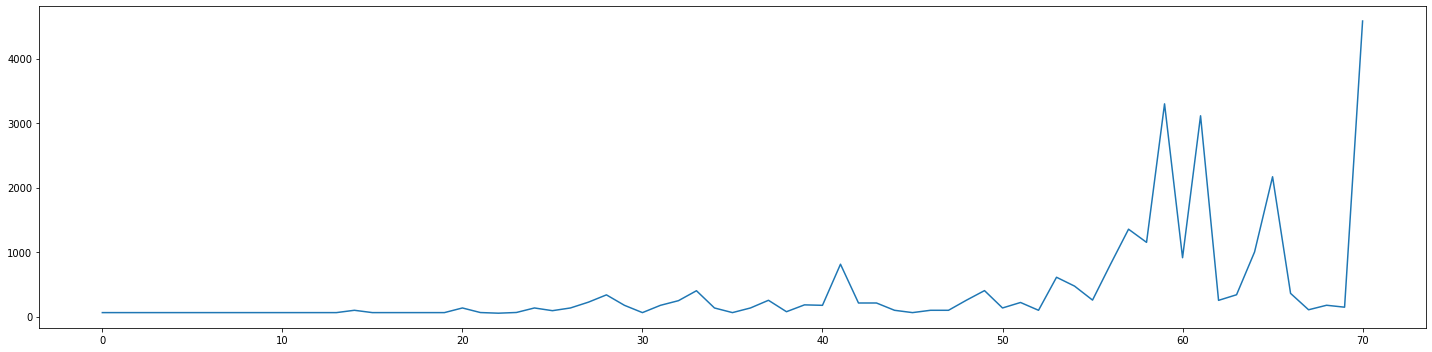

In [9]:
# plot life time against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(lifetime_per_epoch)), lifetime_per_epoch)
fig.tight_layout()
plt.show()

# Q_Learning Reward_per_epoch

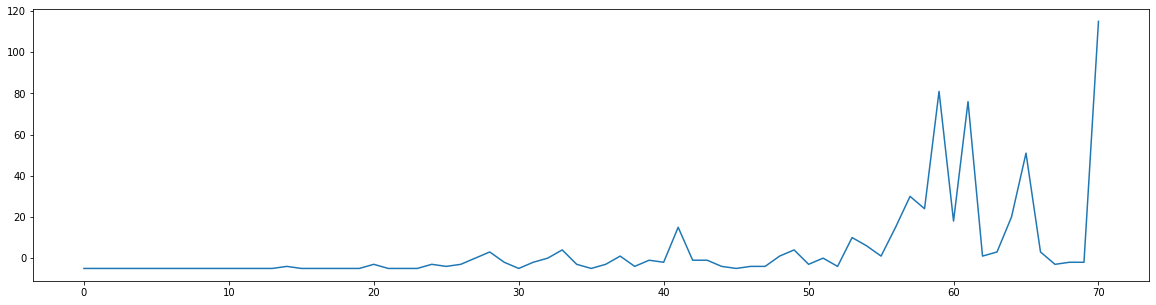

In [10]:
# plot reward against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(reward_per_epoch)), reward_per_epoch)
plt.show()

# SARSA

In [7]:
from ple.games.flappybird import FlappyBird
from ple import PLE
import matplotlib.pyplot as plt
import os
import numpy as np
import math
import copy
from collections import defaultdict
from IPython.display import Image, display
import moviepy.editor as mpy

In [8]:
game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

game.getGameState()  

MIN_EXPLORING_RATE = 0.01
MIN_LEARNING_RATE = 0.5


class SARSA_Agent:

    def __init__(self,
                 bucket_range_per_feature,
                 num_action,
                 t=0,
                 discount_factor=0.99):
        self.update_parameters(t)  # init explore rate and learning rate
        self.q_table = defaultdict(lambda: np.zeros(num_action))
        self.discount_factor = discount_factor
        self.num_action = num_action

        # how to discretize each feature in a state
        # the higher each value, less time to train but with worser performance
        # e.g. if range = 2, feature with value 1 is equal to feature with value 0 bacause int(1/2) = int(0/2)
        self.bucket_range_per_feature = bucket_range_per_feature

    def select_action(self, state):
        # epsilon-greedy
        state_idx = self.get_state_idx(state)
        if np.random.rand() < self.exploring_rate:
            action = np.random.choice(num_action)  # Select a random action
        else:
            action = np.argmax(
                self.q_table[state_idx])  # Select the action with the highest q
        return action

    def update_policy(self, state, action, action_prime, reward, state_prime):
        state_idx = self.get_state_idx(state)
        state_prime_idx = self.get_state_idx(state_prime)
        # Update Q_value using Q-learning update rule
        sarsa_q = self.q_table[state_prime_idx][action_prime]
        self.q_table[state_idx][action] += self.learning_rate * (
            reward + self.discount_factor * sarsa_q - self.q_table[state_idx][action])

    def get_state_idx(self, state):
        # instead of using absolute position of pipe, use relative position
        state = copy.deepcopy(state)
        state['next_next_pipe_bottom_y'] -= state['player_y']
        state['next_next_pipe_top_y'] -= state['player_y']
        state['next_pipe_bottom_y'] -= state['player_y']
        state['next_pipe_top_y'] -= state['player_y']

        # sort to make list converted from dict ordered in alphabet order
        state_key = [k for k, v in sorted(state.items())]

        # do bucketing to decrease state space to speed up training
        state_idx = []
        for key in state_key:
            state_idx.append(
                int(state[key] / self.bucket_range_per_feature[key]))
        return tuple(state_idx)

    def update_parameters(self, episode):
        self.exploring_rate = max(MIN_EXPLORING_RATE,
                                  min(0.5, 0.99**((episode) / 30)))
        self.learning_rate = max(MIN_LEARNING_RATE, min(0.5, 0.99
                                                        ** ((episode) / 30)))

    def shutdown_explore(self):
        # make action selection greedy
        self.exploring_rate = 0
        

# init agent
sarsa_agent = SARSA_Agent(bucket_range_per_feature, num_action)

In [9]:
reward_per_epoch = []
lifetime_per_epoch = []
exploring_rates = []
learning_rates = []
print_every_episode = 500
show_gif_every_episode = 5000
NUM_EPISODE = 40000
for episode in range(0, NUM_EPISODE):

    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # for every 500 episodes, shutdown exploration to see performance of greedy action
    if episode % print_every_episode == 0:
        sarsa_agent.shutdown_explore()

    # the initial state
    state = game.getGameState()
    # cumulate reward for this episode
    cum_reward = 0  
    t = 0
    
    # select an action
    action = sarsa_agent.select_action(state)

    while not env.game_over():

        # execute the action and get reward
        # reward = +1 when pass a pipe, -5 when die
        reward = env.act(env.getActionSet()[action])  

        frames.append(env.getScreenRGB())

        # cumulate reward
        cum_reward += reward

        # observe the result
        state_prime = game.getGameState()  # get next state

        # select action_prime
        action_prime = sarsa_agent.select_action(state_prime)

        # update agent
        sarsa_agent.update_policy(state, action, action_prime, reward, state_prime)

        # Setting up for the next iteration
        state = state_prime
        action = action_prime
        t += 1

    # update exploring_rate and learning_rate
    sarsa_agent.update_parameters(episode)

    if episode % print_every_episode == 0:
        print("Episode {} finished after {} time steps, cumulated reward: {}, exploring rate: {}, learning rate: {}".format(
            episode,
            t,
            cum_reward,
            sarsa_agent.exploring_rate,
            sarsa_agent.learning_rate
        ))
        reward_per_epoch.append(cum_reward)
        exploring_rates.append(sarsa_agent.exploring_rate)
        learning_rates.append(sarsa_agent.learning_rate)
        lifetime_per_epoch.append(t)

    # for every 5000 episode, record an animation
    if episode % show_gif_every_episode == 0:
        print("len frames:", len(frames))
        clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1))
        

Episode 0 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
len frames: 63
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 1000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 1500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 2000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 2500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.43277903725889943, learning rate: 0.5
Episode 3000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.3660323412732292, learning rate: 0.5
Episode 3500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.30957986252419073, learning rate: 0.5
Episode 4000 finished after 65 time steps, cumulated reward: -5.0, exploring rate: 0.26183394327157605, learning rate: 0.5
Episode 4500 finished after 62 time steps, cumulated reward: -5.0, exploring rate:

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 5500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.15841112426184903, learning rate: 0.5
Episode 6000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.13397967485796172, learning rate: 0.5
Episode 6500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.11331624189077398, learning rate: 0.5
Episode 7000 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.09583969128049684, learning rate: 0.5
Episode 7500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.08105851616218128, learning rate: 0.5
Episode 8000 finished after 66 time steps, cumulated reward: -4.0, exploring rate: 0.0685570138491429, learning rate: 0.5
Episode 8500 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.05798359469728905, learning rate: 0.5
Episode 9000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.04904089407128572, learning rate: 0.5
Episode 9500 fi

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 10500 finished after 106 time steps, cumulated reward: -3.0, exploring rate: 0.029670038450977102, learning rate: 0.5
Episode 11000 finished after 97 time steps, cumulated reward: -4.0, exploring rate: 0.02509408428990297, learning rate: 0.5
Episode 11500 finished after 108 time steps, cumulated reward: -3.0, exploring rate: 0.021223870922486707, learning rate: 0.5
Episode 12000 finished after 211 time steps, cumulated reward: -1.0, exploring rate: 0.017950553275045137, learning rate: 0.5
Episode 12500 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.015182073244652034, learning rate: 0.5
Episode 13000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.012840570676248398, learning rate: 0.5
Episode 13500 finished after 437 time steps, cumulated reward: 5.0, exploring rate: 0.010860193639877882, learning rate: 0.5
Episode 14000 finished after 150 time steps, cumulated reward: -2.0, exploring rate: 0.01, learning rate: 0.5
Episode 14500

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 15500 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.01, learning rate: 0.5
Episode 16000 finished after 211 time steps, cumulated reward: -1.0, exploring rate: 0.01, learning rate: 0.5
Episode 16500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.01, learning rate: 0.5
Episode 17000 finished after 473 time steps, cumulated reward: 6.0, exploring rate: 0.01, learning rate: 0.5
Episode 17500 finished after 925 time steps, cumulated reward: 18.0, exploring rate: 0.01, learning rate: 0.5
Episode 18000 finished after 473 time steps, cumulated reward: 6.0, exploring rate: 0.01, learning rate: 0.5
Episode 18500 finished after 360 time steps, cumulated reward: 3.0, exploring rate: 0.01, learning rate: 0.5
Episode 19000 finished after 204 time steps, cumulated reward: -1.0, exploring rate: 0.01, learning rate: 0.5
Episode 19500 finished after 288 time steps, cumulated reward: 1.0, exploring rate: 0.01, learning rate: 0.5
Episode 20000 f

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 20500 finished after 289 time steps, cumulated reward: 1.0, exploring rate: 0.01, learning rate: 0.5
Episode 21000 finished after 255 time steps, cumulated reward: 1.0, exploring rate: 0.01, learning rate: 0.5
Episode 21500 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 22000 finished after 356 time steps, cumulated reward: 3.0, exploring rate: 0.01, learning rate: 0.5
Episode 22500 finished after 851 time steps, cumulated reward: 16.0, exploring rate: 0.01, learning rate: 0.5
Episode 23000 finished after 90 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 23500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.01, learning rate: 0.5
Episode 24000 finished after 217 time steps, cumulated reward: 0.0, exploring rate: 0.01, learning rate: 0.5
Episode 24500 finished after 995 time steps, cumulated reward: 20.0, exploring rate: 0.01, learning rate: 0.5
Episode 25000 fin

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 25500 finished after 294 time steps, cumulated reward: 2.0, exploring rate: 0.01, learning rate: 0.5
Episode 26000 finished after 217 time steps, cumulated reward: 0.0, exploring rate: 0.01, learning rate: 0.5
Episode 26500 finished after 437 time steps, cumulated reward: 5.0, exploring rate: 0.01, learning rate: 0.5
Episode 27000 finished after 889 time steps, cumulated reward: 17.0, exploring rate: 0.01, learning rate: 0.5
Episode 27500 finished after 776 time steps, cumulated reward: 14.0, exploring rate: 0.01, learning rate: 0.5
Episode 28000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 28500 finished after 211 time steps, cumulated reward: -1.0, exploring rate: 0.01, learning rate: 0.5
Episode 29000 finished after 401 time steps, cumulated reward: 4.0, exploring rate: 0.01, learning rate: 0.5
Episode 29500 finished after 812 time steps, cumulated reward: 15.0, exploring rate: 0.01, learning rate: 0.5
Episode 30000 f

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 30500 finished after 972 time steps, cumulated reward: 20.0, exploring rate: 0.01, learning rate: 0.5
Episode 31000 finished after 288 time steps, cumulated reward: 1.0, exploring rate: 0.01, learning rate: 0.5
Episode 31500 finished after 1131 time steps, cumulated reward: 24.0, exploring rate: 0.01, learning rate: 0.5
Episode 32000 finished after 640 time steps, cumulated reward: 11.0, exploring rate: 0.01, learning rate: 0.5
Episode 32500 finished after 175 time steps, cumulated reward: -2.0, exploring rate: 0.01, learning rate: 0.5
Episode 33000 finished after 1264 time steps, cumulated reward: 27.0, exploring rate: 0.01, learning rate: 0.5
Episode 33500 finished after 324 time steps, cumulated reward: 2.0, exploring rate: 0.01, learning rate: 0.5
Episode 34000 finished after 1539 time steps, cumulated reward: 35.0, exploring rate: 0.01, learning rate: 0.5
Episode 34500 finished after 1079 time steps, cumulated reward: 22.0, exploring rate: 0.01, learning rate: 0.5
Episode 

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 35500 finished after 2019 time steps, cumulated reward: 47.0, exploring rate: 0.01, learning rate: 0.5
Episode 36000 finished after 1091 time steps, cumulated reward: 23.0, exploring rate: 0.01, learning rate: 0.5
Episode 36500 finished after 1151 time steps, cumulated reward: 24.0, exploring rate: 0.01, learning rate: 0.5
Episode 37000 finished after 1942 time steps, cumulated reward: 45.0, exploring rate: 0.01, learning rate: 0.5
Episode 37500 finished after 2435 time steps, cumulated reward: 58.0, exploring rate: 0.01, learning rate: 0.5
Episode 38000 finished after 211 time steps, cumulated reward: -1.0, exploring rate: 0.01, learning rate: 0.5
Episode 38500 finished after 816 time steps, cumulated reward: 16.0, exploring rate: 0.01, learning rate: 0.5
Episode 39000 finished after 1644 time steps, cumulated reward: 37.0, exploring rate: 0.01, learning rate: 0.5
Episode 39500 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5


In [14]:
demo()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


# SARSA lifetime_per_epoch

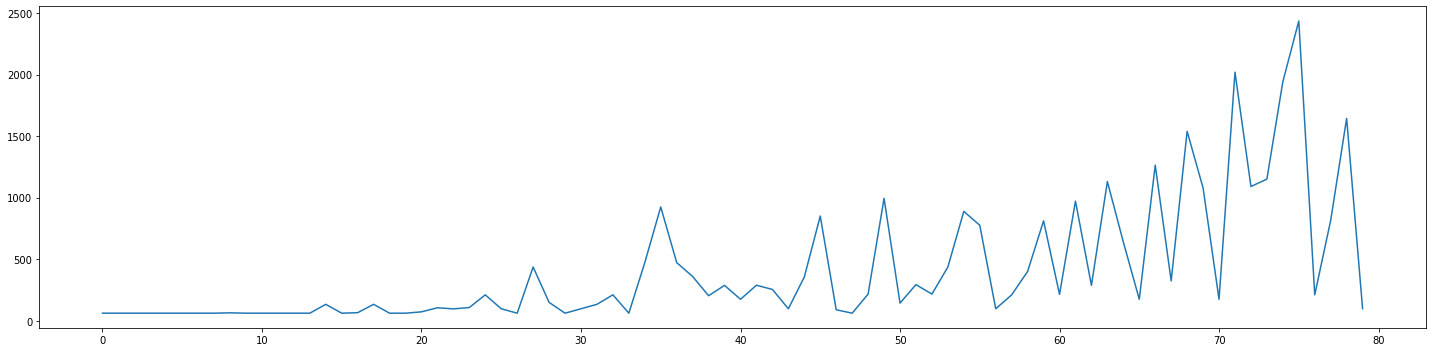

In [11]:
# plot life time against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(lifetime_per_epoch)), lifetime_per_epoch)
fig.tight_layout()
plt.show()

# SARSA reward_per_epoch

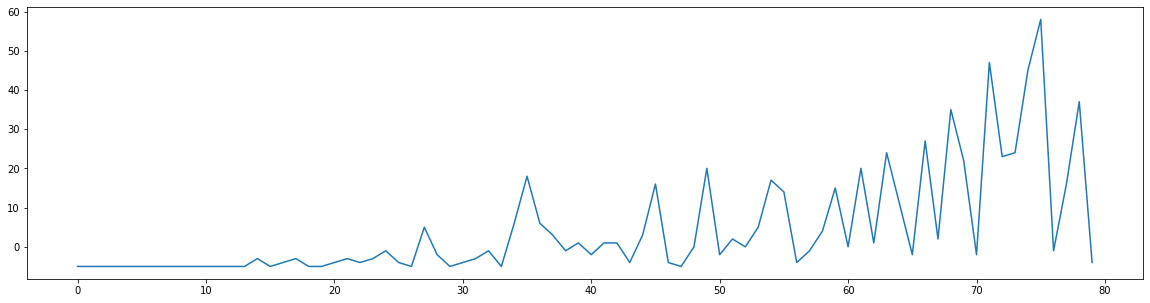

In [12]:
# plot reward against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(reward_per_epoch)), reward_per_epoch)
plt.show()

# Brief Report

這次的作業是要比對Q_Learning和SARSA的表現結果：

以lifetime_per_epoch來說， 
 - Q_Learning在過了epoch60後，就會出現不少lifetime大於3200以上的數值，最後甚至可以突破四千(累計的reward高達115)。
 - SARSA一開始的表現相當不好，然而在過了epoch60後，的確表現開始變好，lifetime也開始和epoch成正比關係，但是最高也不過lifetime到達2500而已。

以reward來說,
 - Q_Learning最高得到的累積reward是115。（但是這也是Q_Learning最後得到的reward，也許memory再加上去，多跑幾個epoch，效果應該會更好）
 - SARSA最高得到的累積reward是85。

總結： 
 - Q_Learning雖然在有限episode下得到的結果是最高的，但是它前面是突然變好的， 效果不太穩定。
 - SARSA雖然表現沒有那麼亮眼，但是在達到一定程度後，SARSA表現開始和時間成正比。
 - 兩者都很不錯，也看出了在選擇Q(s,a)上造成的差異。

*****
由於我的檔案好像無法產生html檔案，助教說可以附上google drive的鏈接也行。

https://drive.google.com/drive/folders/17B3Zvw-vXsnTEek-77cElBCM7jTlFNYR?usp=sharing

我的SARSA FlappyBird影片

https://drive.google.com/file/d/1q-CiiRWjsHTYErQSRv1I9z1x6o3h0VvU/view?usp=sharing